<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/Digital_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount("/content/drive")

import os
import contextlib

# Suppress output
with contextlib.redirect_stdout(None):
    os.system('ls drive/My\\ Drive')

file_path = "/content/drive/MyDrive/Baumgartner screenshots/Arch(AI)ve case study/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **0. Defining relevant functions**

In [21]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps
from PIL import Image, ImageDraw
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
import cv2
from skimage import color

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tqdm import tqdm
def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

    import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
def color_loss(y_true, y_pred):
    # Scale from [0,1] to [0,255]
    y_true = y_true * 255.0
    y_pred = y_pred * 255.0

    # Convert RGB to LAB
    y_true_lab = rgb_to_lab(y_true)
    y_pred_lab = rgb_to_lab(y_pred)

    # Separate L, a, b channels
    L1, a1, b1 = tf.split(y_true_lab, 3, axis=-1)
    L2, a2, b2 = tf.split(y_pred_lab, 3, axis=-1)

    # Delta calculations
    delta_L = L1 - L2
    delta_a = a1 - a2
    delta_b = b1 - b2

    delta_e = tf.sqrt(delta_L**2 + delta_a**2 + delta_b**2)

    return tf.reduce_mean(delta_e)

def rgb_to_lab(srgb):
    srgb = tf.clip_by_value(srgb, 0.0, 255.0)
    srgb = srgb / 255.0

    # Convert sRGB to XYZ
    def f(c):
        return tf.where(c > 0.04045, tf.pow((c + 0.055) / 1.055, 2.4), c / 12.92)
    rgb = f(srgb)

    rgb = tf.reshape(rgb, [-1, 3])
    matrix = tf.constant([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041],
    ], dtype=tf.float32)
    xyz = tf.matmul(rgb, matrix)
    xyz = tf.reshape(xyz, tf.shape(srgb))

    # Normalize for D65 white point
    xyz_ref = [0.95047, 1.0, 1.08883]
    xyz = xyz / xyz_ref

    def f_lab(t):
        delta = 6/29
        return tf.where(t > delta**3, tf.pow(t, 1/3), t / (3 * delta**2) + 4/29)

    f_xyz = f_lab(xyz)

    L = 116 * f_xyz[..., 1] - 16
    a = 500 * (f_xyz[..., 0] - f_xyz[..., 1])
    b = 200 * (f_xyz[..., 1] - f_xyz[..., 2])

    lab = tf.stack([L, a, b], axis=-1)
    return lab

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def crop_patches(image):
    patch_size = 8
    overlap = 4
    stride = patch_size - overlap
    width, height = image.size
    patches_array_rgb = []
    patches_array_lab = []

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patch_data = np.array(patch)

            if patch_data.shape[2] == 4:  # RGBA
                alpha_channel = patch_data[:, :, 3]
                if not np.all(alpha_channel == 255):
                    continue
                patch_rgb = patch_data[:, :, :3]
                patch_lab = rgb_lab_normalized(patch_rgb)
                patches_array_lab.append(patch_lab)
                patches_array_rgb.append(np.array(patch_rgb)/255.0)

                #augment by rotation
                im_lab = np.rot90(patch_lab)
                im_rgb = np.rot90(patch_rgb)
                patches_array_lab.append(im_lab)
                patches_array_rgb.append(np.array(patch_rgb)/255.0)

                im_lab = np.rot90(patch_lab)
                im_rgb = np.rot90(patch_rgb)
                patches_array_lab.append(im_lab)
                patches_array_rgb.append(np.array(patch_rgb)/255.0)

                im_lab = np.rot90(patch_lab)
                im_rgb = np.rot90(patch_rgb)
                patches_array_lab.append(im_lab)
                patches_array_rgb.append(np.array(patch_rgb)/255.0)
    patches_array_rgb

    return np.array(patches_array_rgb), np,array(patches_array_lab)

# **Preparing the training dataset**

In [22]:
# Set directories
painting_name = 'Trees'
before_dir = file_path + painting_name + '/train/before'
after_dir = file_path + painting_name +  '/train/after'

# Collect matching file names
file_names = sorted([f for f in os.listdir(before_dir) if f.endswith('.png')])

# Lists for all patches
input_rgb, output_rgb, input_lab, output_lab = [], [], [], []

# Loop through all matching files
for fname in tqdm(file_names, desc="Processing images"):
    before_path = os.path.join(before_dir, fname)
    after_path = os.path.join(after_dir, fname)

    # Load images with alpha
    before_img = Image.open(before_path).convert("RGBA")
    after_img = Image.open(after_path).convert("RGBA")

    # Crop patches
    before_patches_rgb, before_patches_lab = crop_patches(before_img)
    after_patches_rgb, after_patches_lab = crop_patches(after_img)

    # Sanity check: match counts
    n = min(len(before_patches_rgb), len(after_patches_rgb))
    input_rgb.append(before_patches_rgb[:n])
    output_rgb.append(after_patches_rgb[:n])
    input_lab.append(before_patches_lab[:n])
    output_lab.append(after_patches_lab[:n])
"""
# Stack all patches
input = np.vstack(input)/255
output = np.vstack(output)/255

train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

input = []
output = []

train_input_L = train_input[:,:,:,0:1]
train_input_ab = train_input[:,:,:,1:3]
train_output_L = train_output[:,:,:,0:1]
train_output_ab = train_output[:,:,:,1:3]

test_input_L = test_input[:,:,:,0:1]
test_input_ab = test_input[:,:,:,1:3]
test_output_L = test_output[:,:,:,0:1]
test_output_ab = test_output[:,:,:,1:3]

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

train_input = []
train_output = []
test_input = []
test_output = []
"""

Processing images:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipython-input-1309509210.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
Processing images:   0%|          | 0/12 [00:03<?, ?it/s]

# **2. Training**

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

def unet_model_L(input_shape=(8, 8, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

unet_L = unet_model_L()
unet_L.summary()
#---------------------------------------------------
def unet_model_ab(input_shape=(8, 8, 2)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(2, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

unet_ab = unet_model_ab()
unet_ab.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 1)        │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 32)       │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 2)        │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,434 (40.76 KB)

 Trainable params: 10,434 (40.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.0001)
unet_L.compile(optimizer=opt, loss=losses.MeanSquaredError())
#unet.compile(optimizer=opt, loss=color_loss)
start = time.time()
model = unet_L.fit(train_input_L, train_output_L,
                epochs=100,
                shuffle=True,
                validation_data=(test_input_L, test_output_L),batch_size=32)
end = time.time()


print("The time of execution of above program is :",
      (end-start), "seconds")

unet_L.save(file_path + painting_name + '/unet_L.keras')

#-----------------------------------------------------
opt = Adam(learning_rate=0.0001)
unet_ab.compile(optimizer=opt, loss=losses.MeanSquaredError())
#unet.compile(optimizer=opt, loss=color_loss)
start = time.time()
model = unet_ab.fit(train_input_ab, train_output_ab,
                epochs=100,
                shuffle=True,
                validation_data=(test_input_ab, test_output_ab),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet_ab.save(file_path + painting_name + '/unet_ab.keras')

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0359 - val_loss: 0.0052
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/100
450/450 ━━━━━━━━━

# **3. Test**

/tmp/ipython-input-3783131423.py:18: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1

/tmp/ipython-input-3783131423.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7eae6169cb90>)

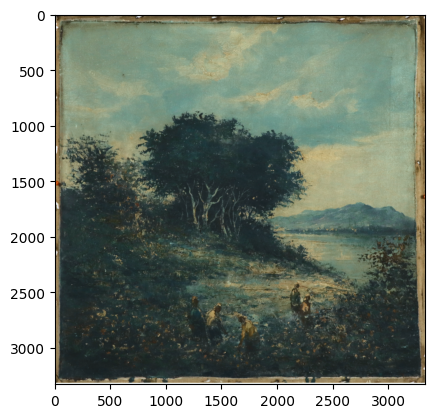

In [15]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
from keras.models import load_model

n_size = 8
size = 8

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

def L_AB_rgb_unnormalized(ab_image, final_L):
    ab_image = ab_image/255.0
    final_L = final_L/255.0
    final_L[..., 0] = final_L[..., 0]*100.0
    ab_image[..., 0] = (ab_image[..., 0] * 255.0) - 128
    ab_image[..., 1] = (ab_image[..., 1] * 255.0) - 128
    LAB_array = np.dstack((final_L, ab_image[:,:,0], ab_image[:,:,1]))
    rgb_array_unnormalized = color.lab2rgb(LAB_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def crop_(im):
    width, height = im.size
    data = []
    for j in np.arange(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            data.append(im1)
    return data


#----------------READING THE TEST IMAGE--------------------#
test = Image.open(file_path + painting_name+ "/"+painting_name+".png").convert('RGB')
test = rgb_lab_normalized(test)
test = ImageOps.expand(test, border=2, fill='black')
w_dirty, h_dirty = test.size
#----------------------------------------------------------#

#----------------GETTING L--------------------#
autoencoder = load_model(file_path + painting_name + '/unet_L.keras')

xx = int(w_dirty/n_size)
final_L=[]
for portion in np.arange(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,0:1]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    #decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,len(decoded_imgs)):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final_L = y
    if portion > 0:
        final_L = np.hstack((final_L,y))

#----------------GETTING AB--------------------#
autoencoder = load_model(file_path + painting_name + '/unet_ab.keras')

xx = int(w_dirty/n_size)
final=[]
for portion in np.arange(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,1:3]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    #decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,len(decoded_imgs)):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))



#----------------TEST ON L from model and AB from model--------------------#
final_L_AB = L_AB_rgb_unnormalized(final, final_L)
final_L_AB = np.squeeze(final_L_AB)
reconstructed_L_AB = Image.fromarray(final_L_AB)
reconstructed_L_AB.save(file_path + painting_name + "/"+painting_name+"_l_ab.png")
plt.figure(), plt.imshow(reconstructed_L_AB)